# Method 9 - Best Ideas Medium Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['herf_pct'] > (1 / 3)) & (best_ideas['herf_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

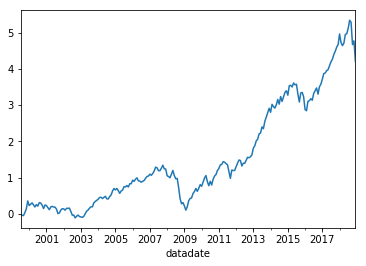

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.352787
2000-12-31   -0.082660
2001-12-31   -0.082409
2002-12-31   -0.191043
2003-12-31    0.485954
2004-12-31    0.239791
2005-12-31    0.078006
2006-12-31    0.115976
2007-12-31    0.094528
2008-12-31   -0.415153
2009-12-31    0.379255
2010-12-31    0.218344
2011-12-31    0.000025
2012-12-31    0.196213
2013-12-31    0.488980
2014-12-31    0.124053
2015-12-31   -0.039293
2016-12-31    0.084091
2017-12-31    0.238646
2018-12-31   -0.081637
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     531.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.34e-114
Time:                        20:19:30   Log-Likelihood:                 650.21
No. Observations:                 234   AIC:                            -1290.
Df Residuals:                     229   BIC:                            -1273.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.400      0.017       0.000       0.005
mktrf          1.0554      0.028     37.242      0.000       1.000       1.111
me             0.2332      0.033      7.075      0.000       0.168       0.298
ia             0.0250      0.050      0.499      0.619      -0.074       0.124
roe            0.1609      0.043      3.752      0.000       0.076       0.245
==============================================================================
Omnibus:                      101.633   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1132.063
Skew:                           1.365   Prob(JB):                    1.50e-246
Kurtosis:                      13.424   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     792.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.79e-133
Time:                        20:19:30   Log-Likelihood:                 650.21
No. Observations:                 234   AIC:                            -1290.
Df Residuals:                     229   BIC:                            -1273.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.773      0.006       0.001       0.004
mktrf          1.0554      0.041     25.676      0.000       0.975       1.136
me             0.2332      0.052      4.506      0.000       0.132       0.335
ia             0.0250      0.127      0.196      0.844      -0.224       0.274
roe            0.1609      0.055      2.935      0.003       0.053       0.268
==============================================================================
Omnibus:                      101.633   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1132.063
Skew:                           1.365   Prob(JB):                    1.50e-246
Kurtosis:                      13.424   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     1016.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.90e-144
Time:                        20:19:30   Log-Likelihood:                 650.21
No. Observations:                 234   AIC:                            -1290.
Df Residuals:                     229   BIC:                            -1273.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.940      0.003       0.001       0.004
mktrf          1.0554      0.044     23.963      0.000       0.969       1.142
me             0.2332      0.042      5.515      0.000       0.150       0.316
ia             0.0250      0.119      0.211      0.833      -0.207       0.257
roe            0.1609      0.060      2.685      0.007       0.043       0.278
==============================================================================
Omnibus:                      101.633   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1132.063
Skew:                           1.365   Prob(JB):                    1.50e-246
Kurtosis:                      13.424   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     392.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.97e-110
Time:                        20:19:30   Log-Likelihood:                 642.20
No. Observations:                 234   AIC:                            -1272.
Df Residuals:                     228   BIC:                            -1252.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.265      0.024       0.000       0.005
mktrf          1.0399      0.029     35.313      0.000       0.982       1.098
smb            0.2680      0.039      6.897      0.000       0.191       0.345
hml           -0.0097      0.046     -0.212      0.832      -0.100       0.081
rmw            0.1467      0.052      2.832      0.005       0.045       0.249
cma            0.0104      0.066      0.158      0.874      -0.119       0.140
==============================================================================
Omnibus:                       99.312   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1049.296
Skew:                           1.341   Prob(JB):                    1.41e-228
Kurtosis:                      13.021   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     587.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.13e-128
Time:                        20:19:30   Log-Likelihood:                 642.20
No. Observations:                 234   AIC:                            -1272.
Df Residuals:                     228   BIC:                            -1252.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.274      0.023       0.000       0.005
mktrf          1.0399      0.038     27.711      0.000       0.966       1.113
smb            0.2680      0.032      8.287      0.000       0.205       0.331
hml           -0.0097      0.066     -0.148      0.882      -0.138       0.119
rmw            0.1467      0.050      2.948      0.003       0.049       0.244
cma            0.0104      0.134      0.078      0.938      -0.252       0.273
==============================================================================
Omnibus:                       99.312   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1049.296
Skew:                           1.341   Prob(JB):                    1.41e-228
Kurtosis:                      13.021   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     708.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.00e-136
Time:                        20:19:30   Log-Likelihood:                 642.20
No. Observations:                 234   AIC:                            -1272.
Df Residuals:                     228   BIC:                            -1252.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.274      0.023       0.000       0.005
mktrf          1.0399      0.038     27.025      0.000       0.965       1.115
smb            0.2680      0.032      8.260      0.000       0.204       0.332
hml           -0.0097      0.069     -0.141      0.887      -0.144       0.125
rmw            0.1467      0.048      3.028      0.002       0.052       0.242
cma            0.0104      0.126      0.083      0.934      -0.236       0.257
==============================================================================
Omnibus:                       99.312   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1049.296
Skew:                           1.341   Prob(JB):                    1.41e-228
Kurtosis:                      13.021   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     566.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.91e-117
Time:                        20:19:30   Log-Likelihood:                 656.91
No. Observations:                 234   AIC:                            -1304.
Df Residuals:                     229   BIC:                            -1287.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.508      0.013       0.001       0.004
mktrf          1.0748      0.025     42.390      0.000       1.025       1.125
smb            0.1438      0.032      4.544      0.000       0.081       0.206
hml            0.1169      0.031      3.719      0.000       0.055       0.179
umd            0.1410      0.021      6.833      0.000       0.100       0.182
==============================================================================
Omnibus:                       74.654   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              497.081
Skew:                           1.057   Prob(JB):                    1.15e-108
Kurtosis:                       9.820   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     535.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.44e-115
Time:                        20:19:30   Log-Likelihood:                 656.91
No. Observations:                 234   AIC:                            -1304.
Df Residuals:                     229   BIC:                            -1287.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.513      0.012       0.001       0.004
mktrf          1.0748      0.041     26.451      0.000       0.995       1.154
smb            0.1438      0.063      2.281      0.023       0.020       0.267
hml            0.1169      0.070      1.671      0.095      -0.020       0.254
umd            0.1410      0.046      3.072      0.002       0.051       0.231
==============================================================================
Omnibus:                       74.654   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              497.081
Skew:                           1.057   Prob(JB):                    1.15e-108
Kurtosis:                       9.820   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     761.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.37e-131
Time:                        20:19:30   Log-Likelihood:                 656.91
No. Observations:                 234   AIC:                            -1304.
Df Residuals:                     229   BIC:                            -1287.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.479      0.013       0.001       0.004
mktrf          1.0748      0.039     27.900      0.000       0.999       1.150
smb            0.1438      0.066      2.170      0.030       0.014       0.274
hml            0.1169      0.069      1.690      0.091      -0.019       0.253
umd            0.1410      0.043      3.265      0.001       0.056       0.226
==============================================================================
Omnibus:                       74.654   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              497.081
Skew:                           1.057   Prob(JB):                    1.15e-108
Kurtosis:                       9.820   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     220.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.20e-53
Time:                        20:19:30   Log-Likelihood:                 309.27
No. Observations:                 120   AIC:                            -608.5
Df Residuals:                     115   BIC:                            -594.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.871      0.064      -0.000       0.007
mktrf          1.1388      0.048     23.526      0.000       1.043       1.235
me             0.2275      0.048      4.757      0.000       0.133       0.322
ia             0.0634      0.075      0.847      0.399      -0.085       0.212
roe            0.2680      0.066      4.044      0.000       0.137       0.399
==============================================================================
Omnibus:                       58.005   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.214
Skew:                           1.499   Prob(JB):                     1.33e-74
Kurtosis:                      10.684   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     330.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.65e-62
Time:                        20:19:30   Log-Likelihood:                 309.27
No. Observations:                 120   AIC:                            -608.5
Df Residuals:                     115   BIC:                            -594.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      2.130      0.033       0.000       0.006
mktrf          1.1388      0.056     20.513      0.000       1.030       1.248
me             0.2275      0.049      4.658      0.000       0.132       0.323
ia             0.0634      0.160      0.397      0.691      -0.249       0.376
roe            0.2680      0.062      4.341      0.000       0.147       0.389
==============================================================================
Omnibus:                       58.005   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.214
Skew:                           1.499   Prob(JB):                     1.33e-74
Kurtosis:                      10.684   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     447.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.35e-69
Time:                        20:19:30   Log-Likelihood:                 309.27
No. Observations:                 120   AIC:                            -608.5
Df Residuals:                     115   BIC:                            -594.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      2.303      0.021       0.001       0.006
mktrf          1.1388      0.053     21.453      0.000       1.035       1.243
me             0.2275      0.039      5.833      0.000       0.151       0.304
ia             0.0634      0.143      0.443      0.658      -0.217       0.344
roe            0.2680      0.053      5.020      0.000       0.163       0.373
==============================================================================
Omnibus:                       58.005   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.214
Skew:                           1.499   Prob(JB):                     1.33e-74
Kurtosis:                      10.684   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     154.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.47e-49
Time:                        20:19:30   Log-Likelihood:                 302.59
No. Observations:                 120   AIC:                            -593.2
Df Residuals:                     114   BIC:                            -576.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      1.884      0.062      -0.000       0.008
mktrf          1.1311      0.054     20.868      0.000       1.024       1.238
smb            0.2813      0.061      4.583      0.000       0.160       0.403
hml           -0.0914      0.075     -1.215      0.227      -0.240       0.058
rmw            0.2700      0.089      3.044      0.003       0.094       0.446
cma            0.1058      0.097      1.089      0.279      -0.087       0.298
==============================================================================
Omnibus:                       45.356   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.310
Skew:                           1.171   Prob(JB):                     1.07e-47
Kurtosis:                       9.147   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     265.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.76e-61
Time:                        20:19:30   Log-Likelihood:                 302.59
No. Observations:                 120   AIC:                            -593.2
Df Residuals:                     114   BIC:                            -576.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.115      0.034       0.000       0.007
mktrf          1.1311      0.066     17.016      0.000       1.001       1.261
smb            0.2813      0.048      5.873      0.000       0.187       0.375
hml           -0.0914      0.112     -0.820      0.412      -0.310       0.127
rmw            0.2700      0.104      2.602      0.009       0.067       0.473
cma            0.1058      0.158      0.669      0.504      -0.204       0.416
==============================================================================
Omnibus:                       45.356   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.310
Skew:                           1.171   Prob(JB):                     1.07e-47
Kurtosis:                       9.147   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     260.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-60
Time:                        20:19:30   Log-Likelihood:                 302.59
No. Observations:                 120   AIC:                            -593.2
Df Residuals:                     114   BIC:                            -576.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.193      0.028       0.000       0.007
mktrf          1.1311      0.064     17.591      0.000       1.005       1.257
smb            0.2813      0.047      6.036      0.000       0.190       0.373
hml           -0.0914      0.117     -0.778      0.436      -0.322       0.139
rmw            0.2700      0.096      2.806      0.005       0.081       0.459
cma            0.1058      0.154      0.689      0.491      -0.195       0.407
==============================================================================
Omnibus:                       45.356   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.310
Skew:                           1.171   Prob(JB):                     1.07e-47
Kurtosis:                       9.147   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     237.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.52e-54
Time:                        20:19:30   Log-Likelihood:                 313.15
No. Observations:                 120   AIC:                            -616.3
Df Residuals:                     115   BIC:                            -602.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      2.982      0.003       0.002       0.008
mktrf          1.1443      0.041     27.712      0.000       1.062       1.226
smb            0.0835      0.047      1.776      0.078      -0.010       0.177
hml            0.1315      0.047      2.792      0.006       0.038       0.225
umd            0.1760      0.029      6.061      0.000       0.118       0.233
==============================================================================
Omnibus:                       31.926   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.389
Skew:                           0.967   Prob(JB):                     1.74e-19
Kurtosis:                       6.679   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     294.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.86e-59
Time:                        20:19:30   Log-Likelihood:                 313.15
No. Observations:                 120   AIC:                            -616.3
Df Residuals:                     115   BIC:                            -602.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      3.288      0.001       0.002       0.008
mktrf          1.1443      0.055     20.650      0.000       1.036       1.253
smb            0.0835      0.070      1.202      0.230      -0.053       0.220
hml            0.1315      0.086      1.537      0.124      -0.036       0.299
umd            0.1760      0.052      3.361      0.001       0.073       0.279
==============================================================================
Omnibus:                       31.926   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.389
Skew:                           0.967   Prob(JB):                     1.74e-19
Kurtosis:                       6.679   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     508.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.10e-72
Time:                        20:19:30   Log-Likelihood:                 313.15
No. Observations:                 120   AIC:                            -616.3
Df Residuals:                     115   BIC:                            -602.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.001      3.437      0.001       0.002       0.008
mktrf          1.1443      0.045     25.306      0.000       1.056       1.233
smb            0.0835      0.068      1.224      0.221      -0.050       0.217
hml            0.1315      0.082      1.607      0.108      -0.029       0.292
umd            0.1760      0.044      4.027      0.000       0.090       0.262
==============================================================================
Omnibus:                       31.926   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.389
Skew:                           0.967   Prob(JB):                     1.74e-19
Kurtosis:                       6.679   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     707.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.58e-77
Time:                        20:19:30   Log-Likelihood:                 391.04
No. Observations:                 114   AIC:                            -772.1
Df Residuals:                     109   BIC:                            -758.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.063      0.003       0.001       0.004
mktrf          0.9743      0.024     41.354      0.000       0.928       1.021
me             0.2705      0.036      7.437      0.000       0.198       0.343
ia            -0.1536      0.050     -3.044      0.003      -0.254      -0.054
roe           -0.1029      0.044     -2.321      0.022      -0.191      -0.015
==============================================================================
Omnibus:                        0.433   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.425
Skew:                           0.142   Prob(JB):                        0.809
Kurtosis:                       2.908   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     1079.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-86
Time:                        20:19:30   Log-Likelihood:                 391.04
No. Observations:                 114   AIC:                            -772.1
Df Residuals:                     109   BIC:                            -758.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.181      0.029       0.000       0.005
mktrf          0.9743      0.018     53.886      0.000       0.939       1.010
me             0.2705      0.039      7.000      0.000       0.195       0.346
ia            -0.1536      0.050     -3.096      0.002      -0.251      -0.056
roe           -0.1029      0.046     -2.217      0.027      -0.194      -0.012
==============================================================================
Omnibus:                        0.433   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.425
Skew:                           0.142   Prob(JB):                        0.809
Kurtosis:                       2.908   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     1242.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.53e-90
Time:                        20:19:30   Log-Likelihood:                 391.04
No. Observations:                 114   AIC:                            -772.1
Df Residuals:                     109   BIC:                            -758.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      1.991      0.046    3.81e-05       0.005
mktrf          0.9743      0.020     49.925      0.000       0.936       1.013
me             0.2705      0.040      6.794      0.000       0.192       0.349
ia            -0.1536      0.050     -3.071      0.002      -0.252      -0.056
roe           -0.1029      0.042     -2.471      0.013      -0.185      -0.021
==============================================================================
Omnibus:                        0.433   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.425
Skew:                           0.142   Prob(JB):                        0.809
Kurtosis:                       2.908   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     600.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.56e-77
Time:                        20:19:30   Log-Likelihood:                 394.78
No. Observations:                 114   AIC:                            -777.6
Df Residuals:                     108   BIC:                            -761.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.941      0.055   -3.23e-05       0.003
mktrf          0.9815      0.022     44.934      0.000       0.938       1.025
smb            0.2566      0.035      7.236      0.000       0.186       0.327
hml           -0.0210      0.045     -0.464      0.644      -0.111       0.069
rmw           -0.1472      0.055     -2.658      0.009      -0.257      -0.037
cma           -0.1199      0.070     -1.706      0.091      -0.259       0.019
==============================================================================
Omnibus:                        1.229   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.541   Jarque-Bera (JB):                0.776
Skew:                           0.157   Prob(JB):                        0.678
Kurtosis:                       3.255   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     912.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.37e-86
Time:                        20:19:30   Log-Likelihood:                 394.78
No. Observations:                 114   AIC:                            -777.6
Df Residuals:                     108   BIC:                            -761.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.391      0.164      -0.001       0.004
mktrf          0.9815      0.016     62.516      0.000       0.951       1.012
smb            0.2566      0.039      6.548      0.000       0.180       0.333
hml           -0.0210      0.052     -0.404      0.686      -0.123       0.081
rmw           -0.1472      0.054     -2.720      0.007      -0.253      -0.041
cma           -0.1199      0.069     -1.738      0.082      -0.255       0.015
==============================================================================
Omnibus:                        1.229   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.541   Jarque-Bera (JB):                0.776
Skew:                           0.157   Prob(JB):                        0.678
Kurtosis:                       3.255   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1217.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.36e-93
Time:                        20:19:30   Log-Likelihood:                 394.78
No. Observations:                 114   AIC:                            -777.6
Df Residuals:                     108   BIC:                            -761.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.264      0.206      -0.001       0.004
mktrf          0.9815      0.016     62.093      0.000       0.950       1.012
smb            0.2566      0.040      6.427      0.000       0.178       0.335
hml           -0.0210      0.061     -0.346      0.729      -0.140       0.098
rmw           -0.1472      0.057     -2.561      0.010      -0.260      -0.035
cma           -0.1199      0.065     -1.843      0.065      -0.247       0.008
==============================================================================
Omnibus:                        1.229   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.541   Jarque-Bera (JB):                0.776
Skew:                           0.157   Prob(JB):                        0.678
Kurtosis:                       3.255   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     702.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.11e-77
Time:                        20:19:30   Log-Likelihood:                 390.64
No. Observations:                 114   AIC:                            -771.3
Df Residuals:                     109   BIC:                            -757.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.033      0.304      -0.001       0.002
mktrf          1.0037      0.022     44.804      0.000       0.959       1.048
smb            0.2854      0.035      8.171      0.000       0.216       0.355
hml           -0.0043      0.036     -0.120      0.905      -0.076       0.067
umd            0.0482      0.027      1.778      0.078      -0.006       0.102
==============================================================================
Omnibus:                        0.143   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.931   Jarque-Bera (JB):                0.310
Skew:                           0.043   Prob(JB):                        0.857
Kurtosis:                       2.759   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     918.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.98e-83
Time:                        20:19:30   Log-Likelihood:                 390.64
No. Observations:                 114   AIC:                            -771.3
Df Residuals:                     109   BIC:                            -757.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.746      0.456      -0.001       0.003
mktrf          1.0037      0.018     56.738      0.000       0.969       1.038
smb            0.2854      0.034      8.411      0.000       0.219       0.352
hml           -0.0043      0.050     -0.086      0.931      -0.102       0.094
umd            0.0482      0.018      2.714      0.007       0.013       0.083
==============================================================================
Omnibus:                        0.143   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.931   Jarque-Bera (JB):                0.310
Skew:                           0.043   Prob(JB):                        0.857
Kurtosis:                       2.759   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1364.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.50e-92
Time:                        20:19:30   Log-Likelihood:                 390.64
No. Observations:                 114   AIC:                            -771.3
Df Residuals:                     109   BIC:                            -757.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.696      0.486      -0.001       0.003
mktrf          1.0037      0.017     59.706      0.000       0.971       1.037
smb            0.2854      0.031      9.351      0.000       0.226       0.345
hml           -0.0043      0.054     -0.079      0.937      -0.111       0.102
umd            0.0482      0.016      3.103      0.002       0.018       0.079
==============================================================================
Omnibus:                        0.143   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.931   Jarque-Bera (JB):                0.310
Skew:                           0.043   Prob(JB):                        0.857
Kurtosis:                       2.759   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""